In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [0]:
folder = 'celebrities'
file = 'celebrities.txt'

In [0]:
from fastai.vision import *
path = Path('gdrive/My Drive/')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [6]:
path.ls()

[PosixPath('gdrive/My Drive/celebrities')]

In [0]:
verify_images('gdrive/My Drive/celebrities/', delete=True, max_size=500)

In [0]:
path = Path('gdrive/My Drive/')

In [0]:

path_hr = path/'celebrities'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [0]:
# path for original folder images
il = ImageList.from_folder(path_hr)

In [0]:
# resize images to jpeg quality and move them different folder
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    # ressize to particular size
    targ_sz = resize_to(img, size, use_min=True)
    # save to JPEG quality which is 60
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [0]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [0]:
# batch size and Base_Model
bs,size=32,128
arch = models.resnet34

In [0]:
# Creating Validation set
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
# loading the data or images after trnasform from databunch object 
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data = get_data(bs,size)

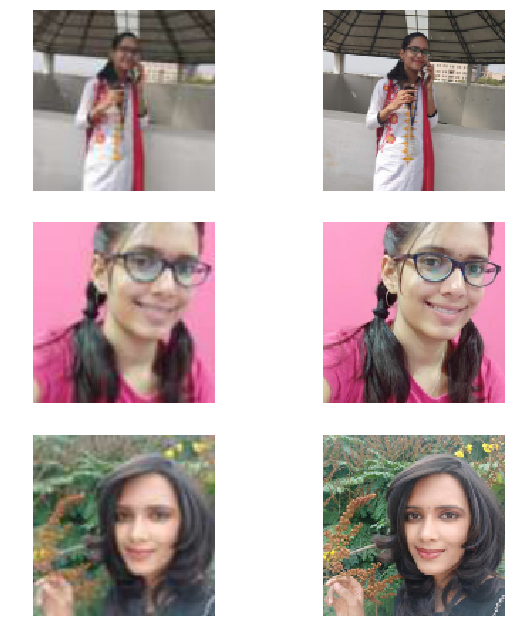

In [17]:
# getting both the images---Blur and HD from the both paths
data.show_batch(ds_type=DatasetType.Valid, rows=3, figsize=(9,9))

## Feature LOsss

In [18]:
t = data.valid_ds[0][1].data
t.shape

torch.Size([3, 128, 128])

In [19]:
# We use this for gram matrix
t = torch.stack([t,t])
t.shape

torch.Size([2, 3, 128, 128])

### Gram Matrix

In [0]:
# Gram matrix
def gram_matrix(x):
    n,c,h,w = x.size()
    # gram matrix at each layer is (c,c) shape
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [21]:
# we  usually take loss of the Gram Matrix
gram_matrix(t).shape

torch.Size([2, 3, 3])

In [0]:
# Loss of the Gram Matrices of both the real and Fake Images
base_loss = F.l1_loss

In [23]:
# .features has convolutn model and no head
# eval mode because we do not train the weights
# requires_grad because we do not update the weights of the model
vgg_m = vgg16_bn(True).features.eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:25<00:00, 21.7MB/s]


In [24]:
# we want to get all the maxpool layers of the model which do conatin the features at gram matrix 
# Why max pool because thats where the grid size changes
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
# layer no just before the maxPool
# these Layers are where we drag our features 
blocks

[5, 12, 22, 32, 42]

In [25]:
[vgg_m[i] for i in blocks]

[ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True)]

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        #m_feat is the model on which we want to generate feature losses on
        self.m_feat = m_feat
        # grab the layers for which u want to create feature losses
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        # hook those outputs of those layers
        self.hooks = hook_outputs(self.loss_features, detach=False)
        # store their weights in layer_wgts
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
      # make features calls the target which ois the VGG model with feature losses or original image feature losses
        out_feat = self.make_features(target, clone=True)
        # input in output of the generator which is input to the target
        in_feat = self.make_features(input)
        # base_losses is pixel loss between input and target
        self.feat_losses = [base_loss(input,target)]
        # activations losses at layer's mentioned below
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        # gram matrix losses of each of the leayer's
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        
        # metricsa is used because prints out all the losses
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        # feat_losses contains sum of the losses 
        # pixel losses + activations losses + gram Matrix losses
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [28]:
wd = 1e-3
# unet trainer with VGG and callback is layer losses
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 24.2MB/s]


In [0]:
lr = 1e-3

In [0]:
# creating a function to train,save model and save Results
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(35, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,6.137766,6.153541,0.981176,0.390436,0.472886,0.196494,1.790737,1.991948,0.329865,01:59
1,5.915826,5.695018,0.788763,0.376742,0.471296,0.195356,1.618298,1.917891,0.326673,02:00
2,5.669826,5.215996,0.616992,0.353730,0.459746,0.181175,1.460945,1.837314,0.306093,01:59
3,5.471190,4.729066,0.420828,0.333231,0.460066,0.172133,1.291438,1.751437,0.299934,02:00
4,5.277553,4.516310,0.324188,0.327545,0.450855,0.158211,1.262287,1.708761,0.284463,02:00
5,5.096451,4.112163,0.294933,0.304294,0.432304,0.146690,1.047286,1.610270,0.276387,01:59
6,4.921548,3.891963,0.276243,0.292251,0.415347,0.138044,0.964232,1.537335,0.268512,01:59
7,4.747077,3.693619,0.250582,0.282668,0.394491,0.130399,0.900290,1.474519,0.260670,01:59
8,4.587447,3.548858,0.232035,0.273244,0.378216,0.127815,0.846069,1.429219,0.262259,01:59
9,4.433180,3.434479,0.211707,0.265316,0.367478,0.123553,0.822800,1.389004,0.254621,01:59


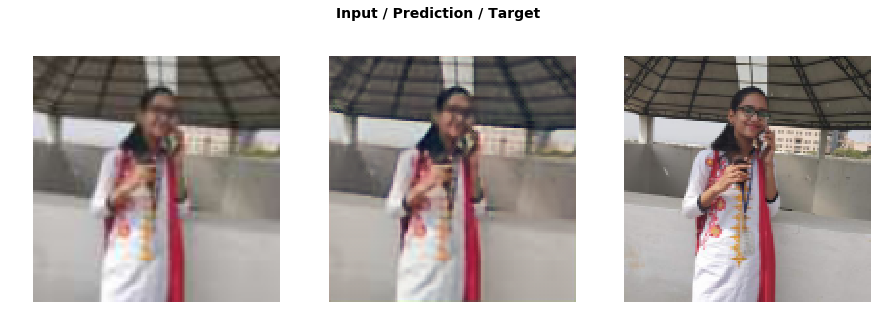

In [31]:
do_fit('1a', slice(lr*10))

## TEST


In [0]:
# using the same unet learner
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [0]:
# creating a data bunch from the earlier trained 256 size images
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [0]:
# loading the previous model
learn.load('1a');

In [0]:
# data of  256 size
learn.data = data_mr

In [36]:
# taking the validation data from the data of size 256
fn = data_mr.valid_ds.x.items[0]; fn

PosixPath('gdrive/My Drive/small-256/IMG_20190218_112923.jpg')

In [37]:
img = open_image(fn); img.shape

torch.Size([3, 341, 256])

In [0]:
# predicting the 256 size image using earlier trained model
p,img_hr,b = learn.predict(img)

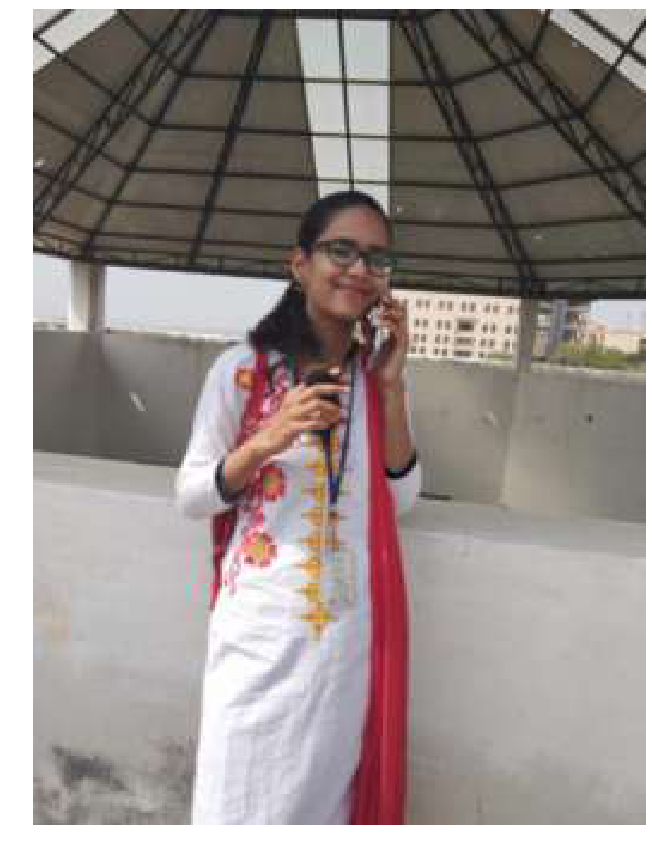

In [39]:
# Original Image
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


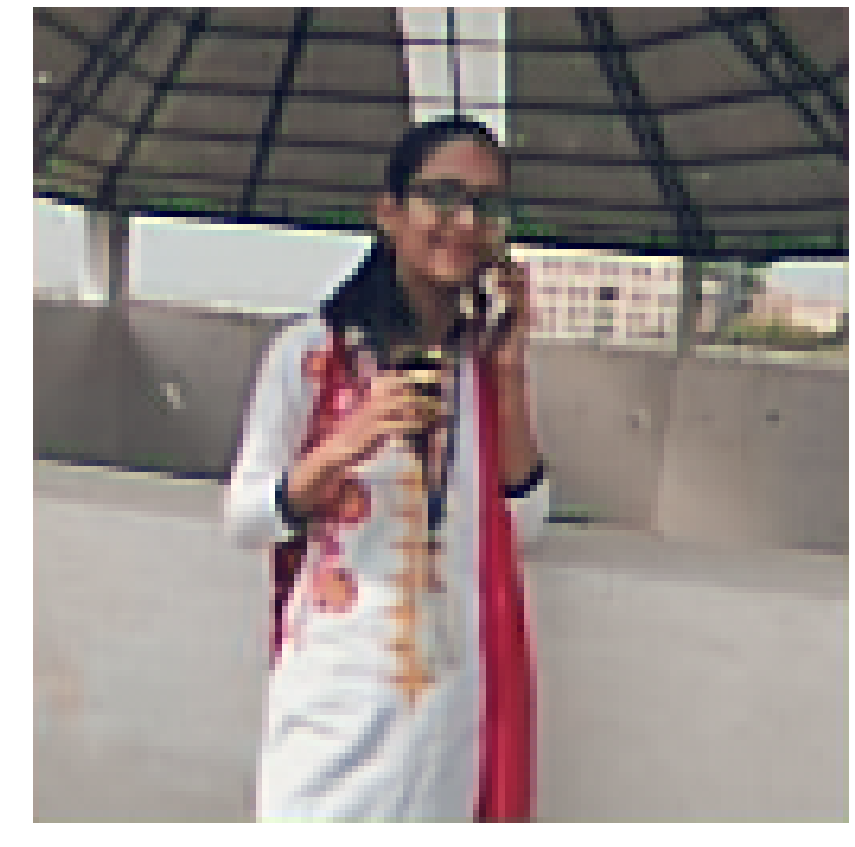

In [40]:
# Predicted Image
Image(img_hr).show(figsize=(18,15))